# WISE – BPIC 2019 Full Analysis (Norm‑based, Slice‑first, Explainable)

This notebook walks through an end‑to‑end analysis of the **BPIC 2019 P2P** log
using the **WISE** norm‑based scoring method, extended with:

- clear, consistent interpretation of all scores,
- slice‑first prioritisation (hotspot ranking),
- layer × slice heatmaps,
- interactive drill‑down from *slice → layer → constraint*,
- SHAP / LIME explanations on top of WISE scores,
- clustering of slices by violation pattern.

> **Convention:** all code cells are tagged with `python`, everything else is
> narrative. You can convert this Markdown file to a notebook via
> `jupytext --to ipynb WISE_BPIC19_full_analysis_v2.md`.

---

## 0. Imports and configuration

In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pm4py
from pm4py.algo.filtering.dfg import dfg_filtering

from wise.io.log_loader import load_event_log
from wise.io.norm_loader import load_norm_from_json
from wise.scoring.scoring import compute_case_scores
from wise.scoring.slices import aggregate_slices

# Optional: SHAP / LIME / scikit-learn
try:
    import shap
    from lime.lime_tabular import LimeTabularExplainer
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.cluster import KMeans

    HAS_XAI = True
except ImportError:
    HAS_XAI = False

import ipywidgets as widgets
from ipywidgets import Dropdown, VBox, HBox, Output

Set basic plotting defaults.

In [2]:
plt.style.use("default")
sns.set_theme()

---

## 1. Load data and norm

You can point the paths to your local copies of the BPIC 2019 log and the
WISE norm file.

In [3]:
# Paths (adapt to your structure)
DATA_DIR = Path("../../../data")
LOG_PATH = DATA_DIR / "BPI_Challenge_2019.csv"
NORM_PATH = DATA_DIR / "WISE_BPIC_Norm.json"

# Core columns in the BPIC 2019 event log
CASE_ID_COL = "case concept:name"
ACTIVITY_COL = "event concept:name"
TIMESTAMP_COL = "event time:timestamp"

# Slice columns to carry through to case level
SLICE_COLS = [
    "case Spend area text",
    "case Company",
    "case Document Type",
    "case Item Type",
    "case Item Category",
    "case Spend classification text",
    "case Source",
    "case GR-Based Inv. Verif.",
    "case Goods Receipt",
]

VIEW_NAME = "Finance"   # WISE view to analyse (must exist in the norm)

### 1.1 Load event log

In [4]:
print(f"Loading log from {LOG_PATH} ...")

# Use latin1 to avoid Unicode errors on this dataset
df_raw = pd.read_csv(LOG_PATH, encoding="latin1", low_memory=False)

df_log = load_event_log(
    df_raw,
    case_id_col=CASE_ID_COL,
    activity_col=ACTIVITY_COL,
    timestamp_col=TIMESTAMP_COL,
)

print(f"Events: {len(df_log):,}, Cases: {df_log[CASE_ID_COL].nunique():,}")

Loading log from ../../../data/BPI_Challenge_2019.csv ...
Events: 1,595,923, Cases: 251,734
Events: 1,595,923, Cases: 251,734


### 1.2 Load WISE norm

In [5]:
print(f"Loading WISE norm from {NORM_PATH} ...")
with open(NORM_PATH, "r", encoding="utf-8") as f:
    norm = load_norm_from_json(f)

print("Views in norm:", norm.get_view_names())

Loading WISE norm from ../../../data/WISE_BPIC_Norm.json ...
Views in norm: ['Finance', 'Logistics', 'Automation']


---

## 2. Choose which part of the P2P process to analyse

The data provider mentioned different process types, often encoded in

- `case Document Type` (Standard PO, Framework order, EC Purchase order, …),
- `case Item Category` (3‑way / 2‑way / consignment, …),
- `case Source` (e.g. PO vs Free text).

It is usually more informative to analyse **one process type at a time** and
compare their flows, instead of mixing everything into a single spaghetti
model.

Mathematically, we restrict the log to a subset of cases:

\[
L' = \{ e \in L \mid f(\text{case}(e)) \},
\]

where \( f \) is a Boolean condition on case attributes.

In [6]:
# Define high-level filters you might want to use
FILTERS = {
    "All POs": {},  # no restriction
    "Standard POs only": {"case Document Type": ["Standard PO"]},
    "Framework orders only": {"case Document Type": ["Framework order"]},
    "EC purchase orders": {"case Document Type": ["EC Purchase order"]},
}

FILTER_NAME = "All POs"  # select here

filter_cfg = FILTERS[FILTER_NAME]
df_sub = df_log.copy()

for col, allowed in filter_cfg.items():
    df_sub = df_sub[df_sub[col].isin(allowed)]

print(
    f"Filtered log [{FILTER_NAME}]: {len(df_sub):,} events, "
    f"{df_sub[CASE_ID_COL].nunique():,} cases"
)

Filtered log [All POs]: 1,595,923 events, 251,734 cases


---

## 3. Describe the control‑flow (high‑level) per document type

To avoid spaghetti, we discover a simple directly‑follows graph (DFG) for each
document type and keep only the main paths that explain ~80 % of behaviour.


Document type: Standard PO
  Events: 1,539,913, Cases: 248,755
  Events: 1,539,913, Cases: 248,755
  Showing main DFG (≈ 80% of behaviour)
  Showing main DFG (≈ 80% of behaviour)


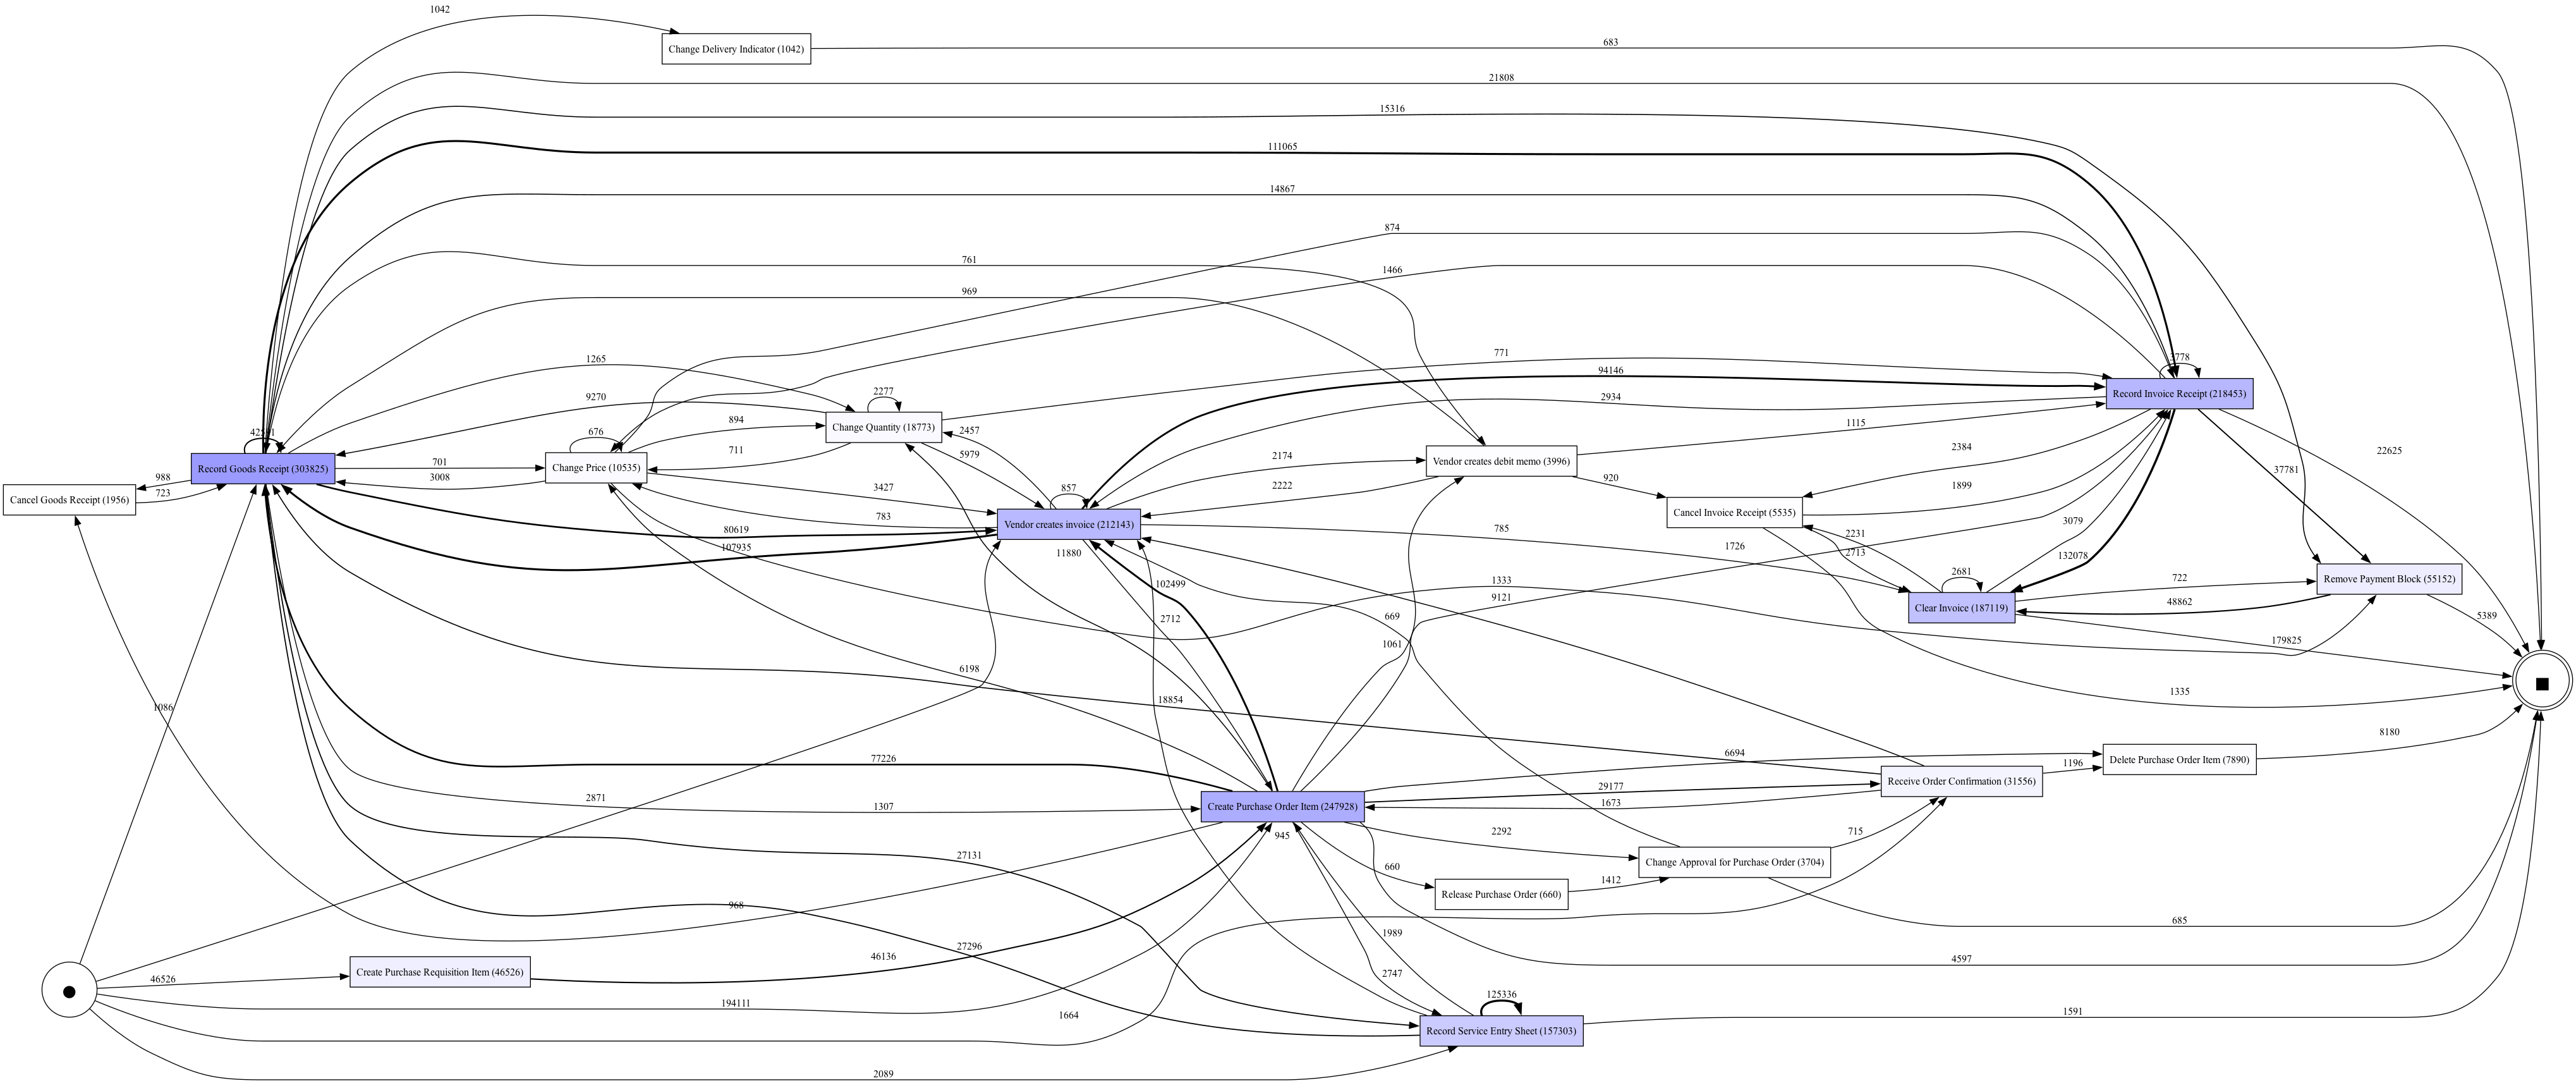


Document type: Framework order
  Events: 33,649, Cases: 1,539
  Showing main DFG (≈ 80% of behaviour)
  Showing main DFG (≈ 80% of behaviour)


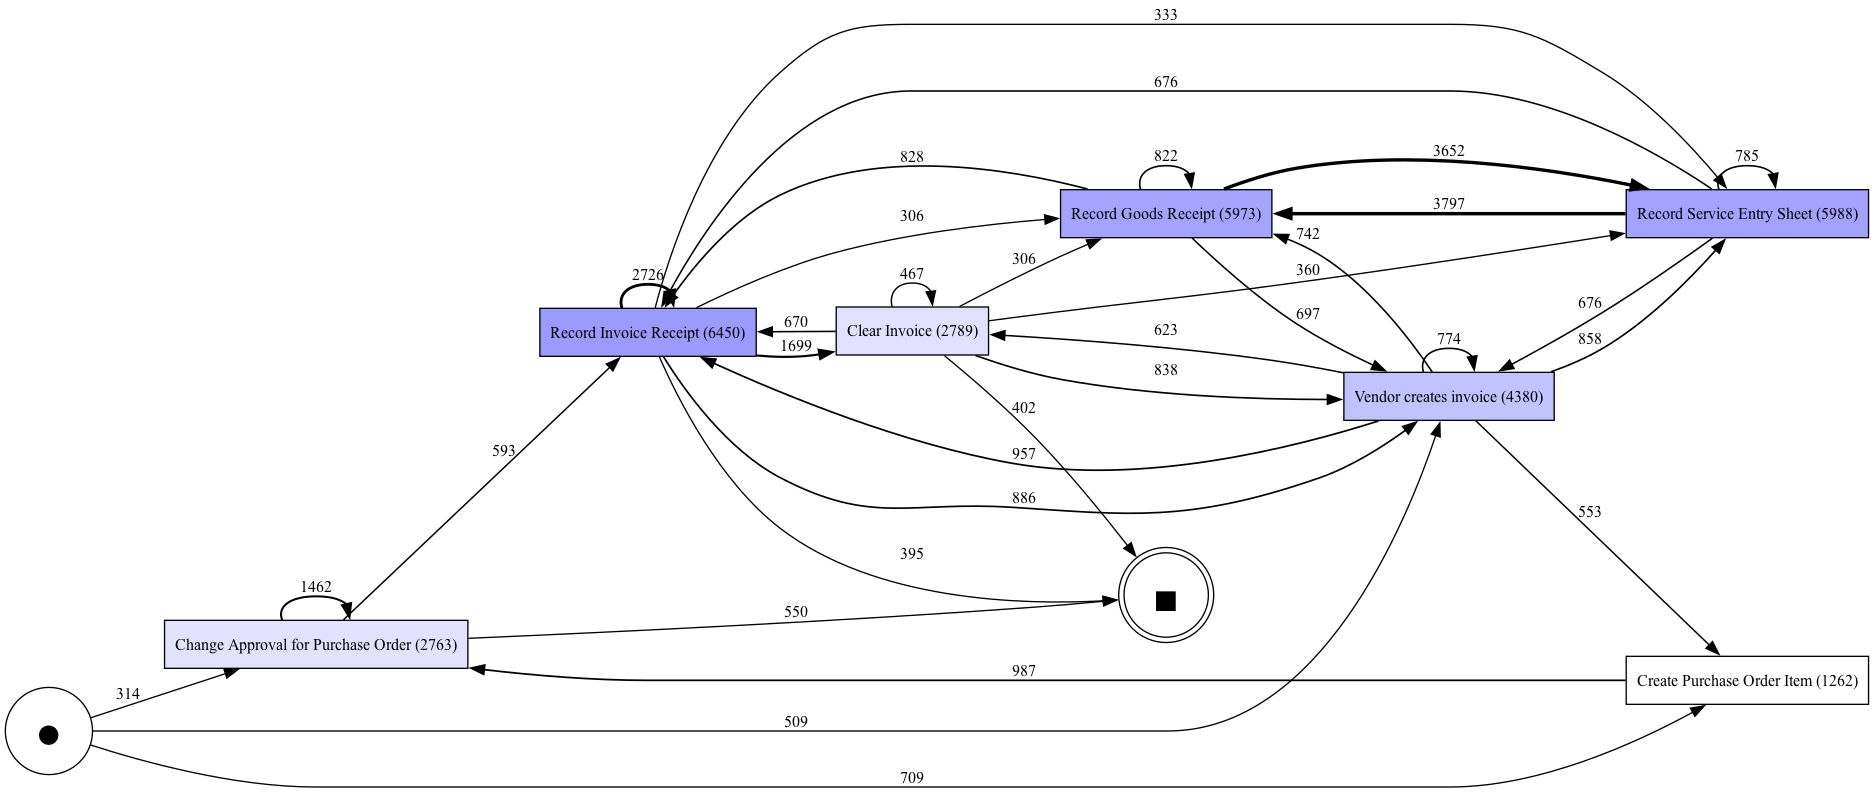


Document type: EC Purchase order
  Events: 22,361, Cases: 1,440
  Showing main DFG (≈ 80% of behaviour)
  Events: 22,361, Cases: 1,440
  Showing main DFG (≈ 80% of behaviour)


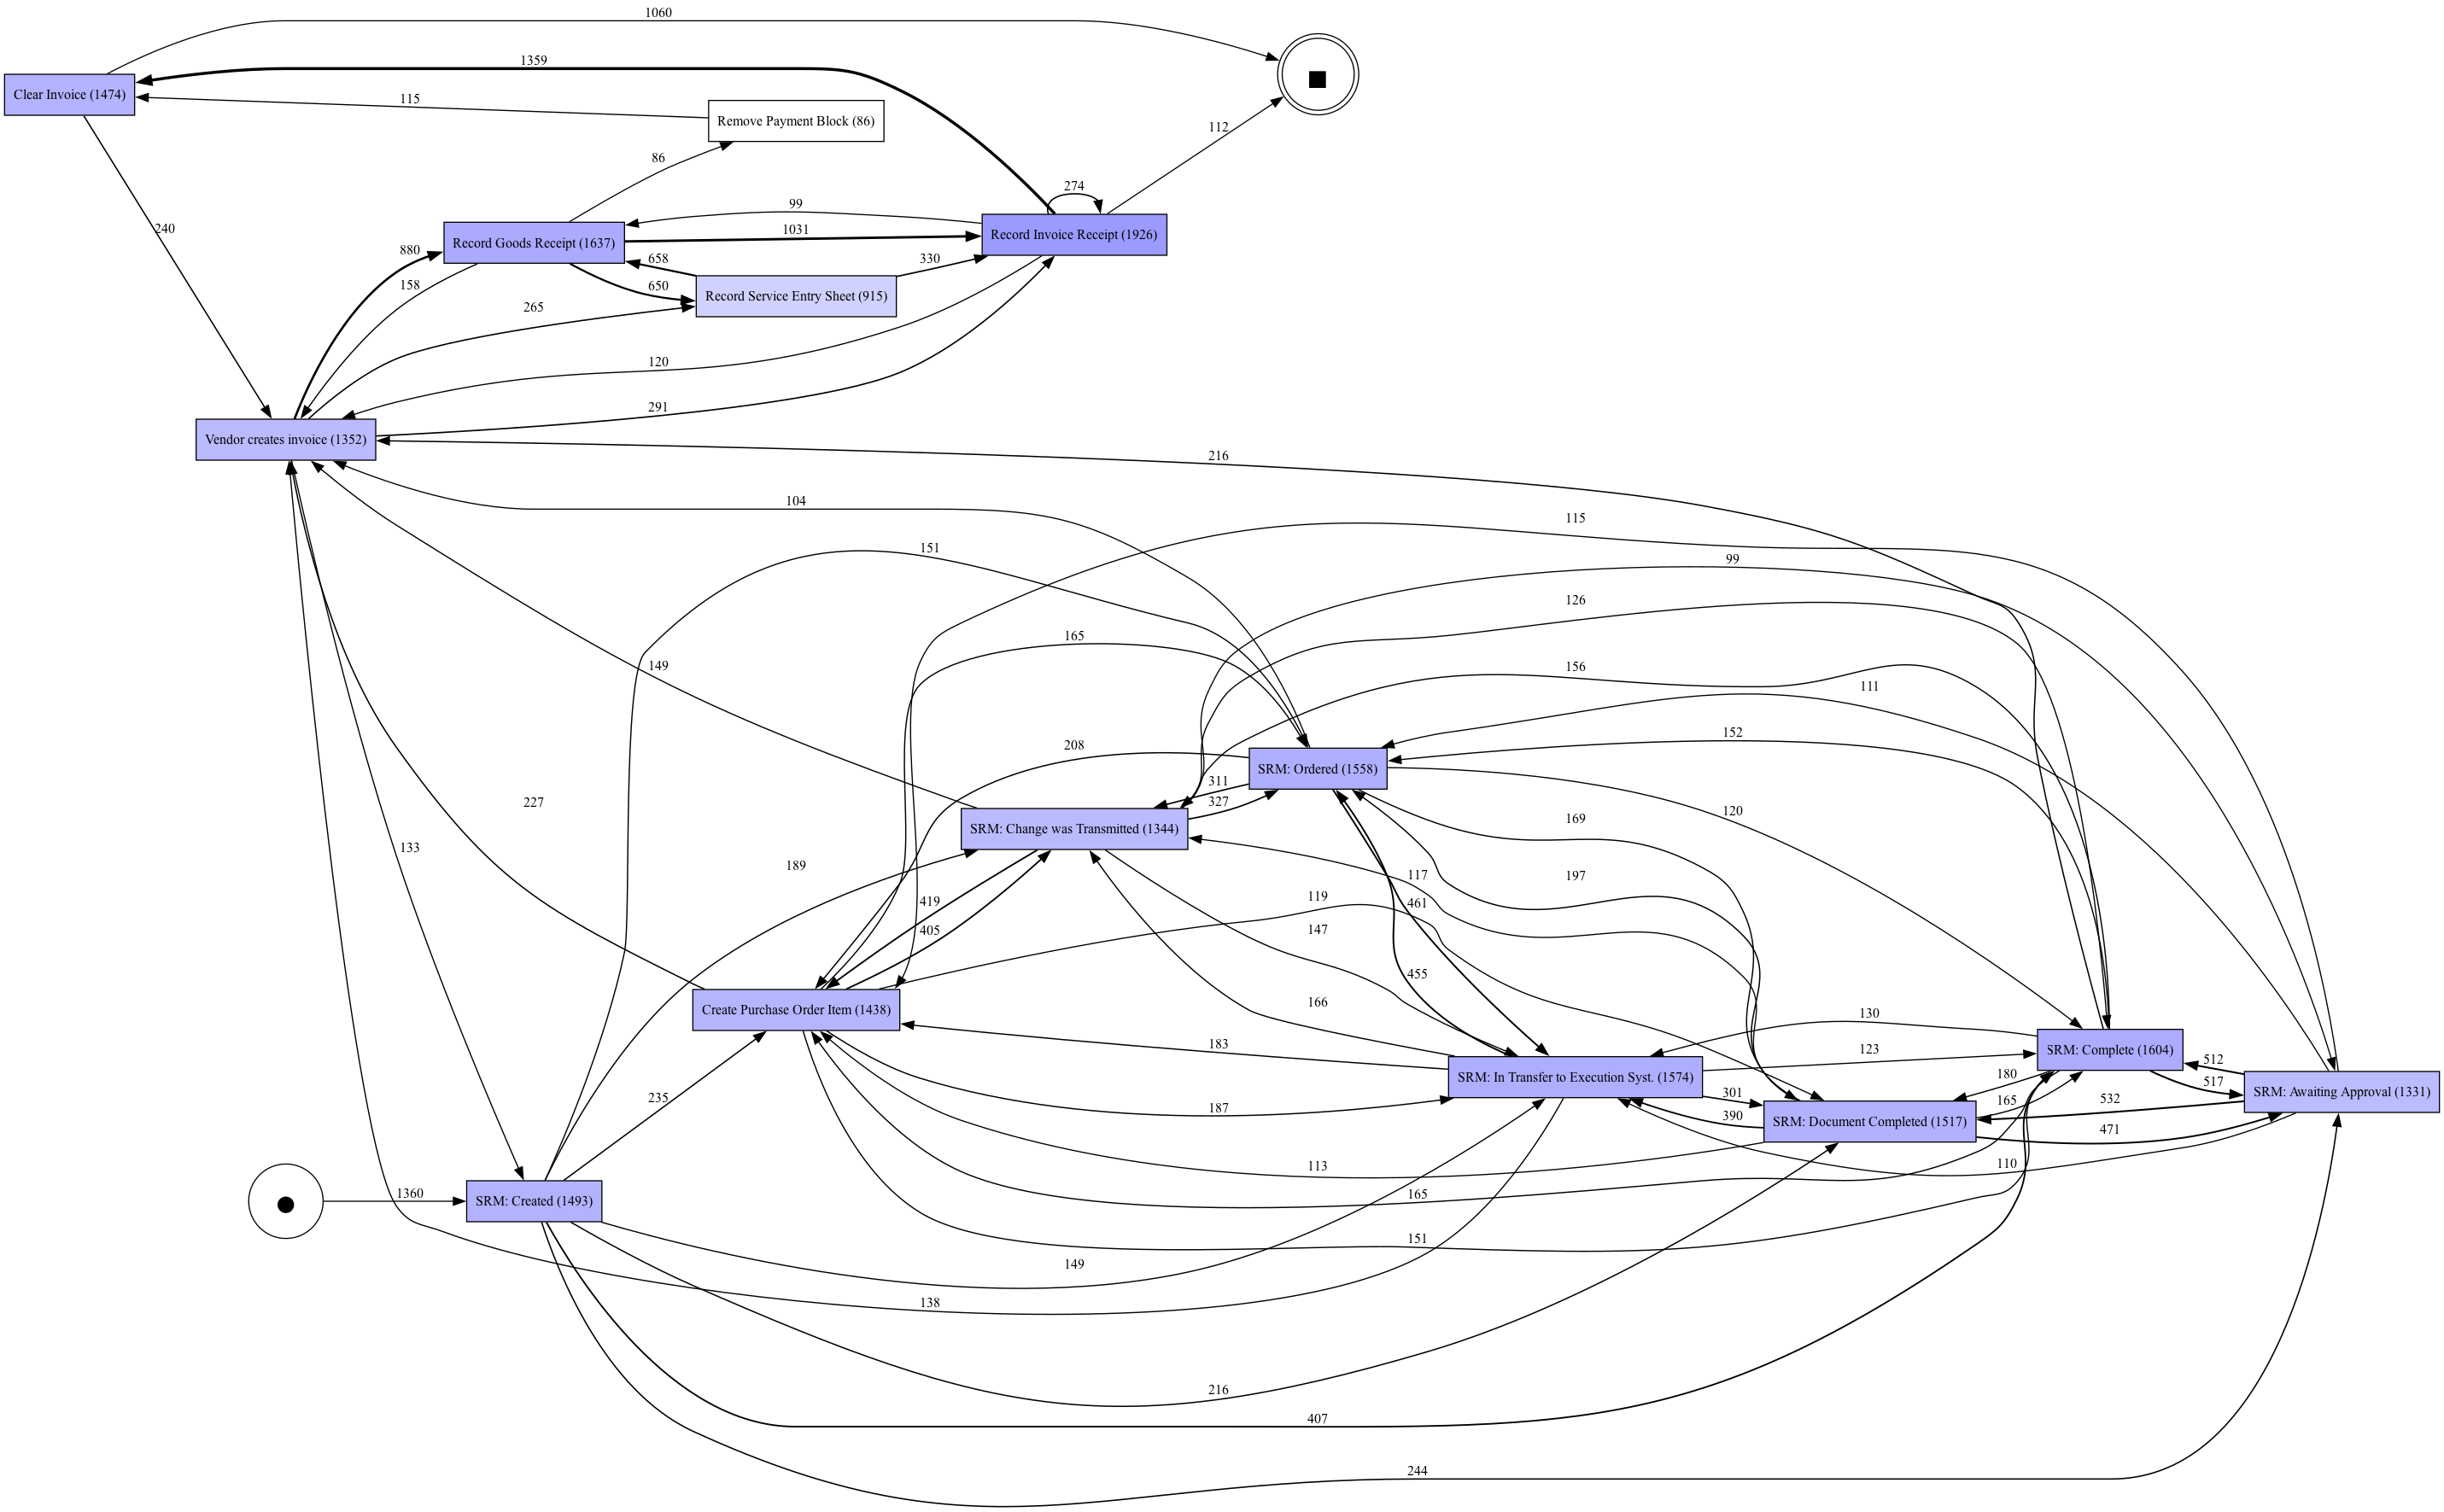

In [7]:
DOC_COL = "case Document Type"
doc_values = df_sub[DOC_COL].dropna().unique()

for doc_type in doc_values:
    print("\n============================")
    print(f"Document type: {doc_type}")

    df_dt = df_sub[df_sub[DOC_COL] == doc_type].copy()
    n_events = len(df_dt)
    n_cases = df_dt[CASE_ID_COL].nunique()
    print(f"  Events: {n_events:,}, Cases: {n_cases:,}")

    if n_cases == 0:
        continue

    df_pm = df_dt[[CASE_ID_COL, ACTIVITY_COL, TIMESTAMP_COL]].rename(
        columns={
            CASE_ID_COL: "case_id",
            ACTIVITY_COL: "activity",
            TIMESTAMP_COL: "timestamp",
        }
    )
    df_pm = pm4py.format_dataframe(
        df_pm, case_id="case_id", activity_key="activity", timestamp_key="timestamp"
    )

    dfg, start_acts, end_acts = pm4py.discover_dfg(df_pm)

    # Keep only main paths (covering ~80 % of behaviour)
    activities = pm4py.get_event_attribute_values(df_pm, "activity")
    dfg_main, sa_main, ea_main, _ = dfg_filtering.filter_dfg_on_paths_percentage(
        dfg, start_acts, end_acts, activities, 0.2
    )

    print("  Showing main DFG (≈ 80% of behaviour)")
    pm4py.view_dfg(dfg_main, sa_main, ea_main)

---

## 4. Compute case‑level WISE scores

In [8]:
from pathlib import Path

# You can cache scores to avoid recomputation
RESULTS_DIR = DATA_DIR / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

SCORES_BASE_NAME = f"case_scores_{VIEW_NAME.replace(' ', '_')}_{FILTER_NAME.replace(' ', '_')}"
PATH_SCORES_CSV = RESULTS_DIR / f"{SCORES_BASE_NAME}.csv"

LOAD_SCORES = PATH_SCORES_CSV.exists()   # load if available
SAVE_SCORES = True                       # save after computation

if LOAD_SCORES:
    print(f"Loading previously saved case scores from {PATH_SCORES_CSV} ...")
    case_scores = pd.read_csv(PATH_SCORES_CSV)
else:
    print("Computing WISE case scores ...")
    case_scores = compute_case_scores(
        df=df_sub,
        norm=norm,
        view_name=VIEW_NAME,
        case_id_col=CASE_ID_COL,
        activity_col=ACTIVITY_COL,
        timestamp_col=TIMESTAMP_COL,
    )

    if SAVE_SCORES:
        case_scores.to_csv(PATH_SCORES_CSV, index=False)
        print(f"Saved case scores to {PATH_SCORES_CSV}")

print("Case scores shape:", case_scores.shape)
case_scores.head()

Loading previously saved case scores from ../../../data/results/case_scores_Finance_All_POs.csv ...
Case scores shape: (251734, 22)
Case scores shape: (251734, 22)


case concept:name     score  violation_exclusion  violation_order_lag  \
0  2000000000_00001  0.999275                 0.00             0.011111   
1  2000000001_00001  0.927536                 0.00             0.222222   
2  2000000002_00001  0.847826                 0.25             0.333333   
3  2000000003_00001  0.934783                 0.00             0.333333   
4  2000000003_00002  0.934783                 0.00             0.333333   

   violation_presence  violation_singularity  viol_c_l1_create_po  \
0                 0.0                    0.0                  0.0   
1                 0.0                    0.0                  0.0   
2                 0.0                    0.4                  0.0   
3                 0.0                    0.0                  0.0   
4                 0.0                    0.0                  0.0   

   viol_c_l1_gr  viol_c_l1_inv  viol_c_l1_clear  ...  \
0           0.0            0.0              0.0  ...   
1           0.0            0.0              0.0  ...   
2           0.0            0.0              0.0  ...   
3           0.0            0.0              0.0  ...   
4           0.0            0.0              0.0  ...   

   viol_c_l2_inv_to_clear_30d  viol_c_l4_sing_gr  viol_c_l4_sing_inv  \
0                    0.000000                0.0                 0.0   
1                    0.666667                0.0                 0.0   
2                    0.000000                1.0                 0.0   
3                    0.000000                0.0                 0.0   
4                    0.000000                0.0                 0.0   

   viol_c_l4_sing_ses  viol_c_l4_sing_change_price  \
0                 0.0                          0.0   
1                 0.0                          0.0   
2                 1.0                          0.0   
3                 0.0                          0.0   
4                 0.0                          0.0   

   viol_c_l4_sing_change_quantity  viol_c_l5_excl_cancel_invoice  \
0                             0.0                            0.0   
1                             0.0                            0.0   
2                             0.0                            0.0   
3                             0.0                            0.0   
4                             0.0                            0.0   

   viol_c_l5_excl_cancel_gr  viol_c_l5_excl_subseq_invoice  \
0                       0.0                            0.0   
1                       0.0                            0.0   
2                       1.0                            0.0   
3                       0.0                            0.0   
4                       0.0                            0.0   

   viol_c_l5_excl_subseq_credit  
0                           0.0  
1                           0.0  
2                           0.0  
3                           0.0  
4                           0.0  

[5 rows x 22 columns]

### 4.1 How to read the WISE scores

In [9]:
%%markdown
### Semantics of WISE scores

All WISE scores in this notebook follow the same convention:

- **Case score `score`** is in \([0,1]\).
  - `1.0` → the case perfectly satisfies every constraint in the norm (for the
    selected view).
  - `0.0` → the case reaches the maximum possible violation (every constraint
    fully violated).
  - Example: `0.93` vs `0.80` → the latter is clearly worse, with more weighted
    violations.

Let $ C $ be the set of constraints, $ w_c^{(v)} $ the weight of
constraint $c$ in view $v$, and $ v_c(\sigma) \in [0,1] $ the
violation of constraint $c$ for case $\sigma$. Then

$$
S^{(v)}(\sigma)
= 1 - \sum_{c \in C} w_c^{(v)} \, v_c(\sigma),
\qquad S^{(v)}(\sigma) \in [0,1].
$$

Higher is **better** (closer to the norm). A difference of `0.05` roughly
means “5 percentage‑points more weighted violation”.

We will also use

- **badness** = `1 - score` in $[0,1]$, so **higher badness = worse case**.

### Semantics of WISE scores

All WISE scores in this notebook follow the same convention:

- **Case score `score`** is in \([0,1]\).
  - `1.0` → the case perfectly satisfies every constraint in the norm (for the
    selected view).
  - `0.0` → the case reaches the maximum possible violation (every constraint
    fully violated).
  - Example: `0.93` vs `0.80` → the latter is clearly worse, with more weighted
    violations.

Let $ C $ be the set of constraints, $ w_c^{(v)} $ the weight of
constraint $c$ in view $v$, and $ v_c(\sigma) \in [0,1] $ the
violation of constraint $c$ for case $\sigma$. Then

$$
S^{(v)}(\sigma)
= 1 - \sum_{c \in C} w_c^{(v)} \, v_c(\sigma),
\qquad S^{(v)}(\sigma) \in [0,1].
$$

Higher is **better** (closer to the norm). A difference of `0.05` roughly
means “5 percentage‑points more weighted violation”.

We will also use

- **badness** = `1 - score` in $[0,1]$, so **higher badness = worse case**.


In [10]:
case_scores["badness"] = 1.0 - case_scores["score"]

---

## 5. Slice‑level aggregation and Priority Index

We now join slice attributes to case‑level scores and aggregate.

In [11]:
available_slice_cols = [c for c in SLICE_COLS if c in df_sub.columns]
print("Available slice columns:", available_slice_cols)

if available_slice_cols:
    slice_summary = aggregate_slices(
        df_scores=case_scores,
        df_log=df_sub,
        case_id_col=CASE_ID_COL,
        slice_cols=available_slice_cols,
        shrink_k=50.0,   # Empirical-Bayes shrinkage
    )
    print("Slice summary shape:", slice_summary.shape)
    slice_summary.head()
else:
    slice_summary = None
    print("No slice columns available; skipping slice-level aggregation.")

Available slice columns: ['case Spend area text', 'case Company', 'case Document Type', 'case Item Type', 'case Item Category', 'case Spend classification text', 'case Source', 'case GR-Based Inv. Verif.', 'case Goods Receipt']
Slice summary shape: (115, 14)
Slice summary shape: (115, 14)


%%markdown
### Slice metrics

For each slice $s$ (e.g. Company × Spend area × Item Category), let

- `mean_score` $ \mu_s = \mathbb{E}[S(\sigma) \mid \sigma \in s] $,
- `global_mean_score` $ \bar{\mu} = \mathbb{E}[S(\sigma)] $,
- `gap` = `global_mean_score - mean_score`,
- `PI` = `n_cases * gap`.

Interpretation:

- `gap > 0` → slice is **worse than global** (lower scores).  
- `gap < 0` → slice is **better than global**.  
- `PI` (Priority Index) combines **severity** (`gap`) and **volume**
  (`n_cases`); higher `PI` means the slice both deviates from the norm **and**
  affects many cases.

---

## 6. Layer × slice anomaly ranking and heatmaps

### 6.1 Utility: high‑quality heatmap

In [12]:
def plot_layer_slice_heatmap(
    df_heat: pd.DataFrame,
    value_col: str,
    title: str,
    vcenter: float | None = 0.0,
    fmt: str = ".3f",
    cmap: str = "RdYlGn_r",
    figsize_scale: float = 0.5,
):
    """Generic, high‑res heatmap for layer × slice matrices."""
    if df_heat.empty:
        print("No data to plot.")
        return

    mat = df_heat.pivot(index="layer_id", columns="slice_label", values=value_col)

    desired_order = ["presence", "order_lag", "balance", "singularity", "exclusion"]
    order = [l for l in desired_order if l in mat.index] + [
        l for l in mat.index if l not in desired_order
    ]
    mat = mat.loc[order]

    mat.columns = [str(c) for c in mat.columns]
    mat.index = [str(i) for i in mat.index]

    fig_w = max(8, figsize_scale * mat.shape[1])
    fig_h = 5
    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=160)

    if vcenter is not None:
        vmin = np.nanmin(mat.values)
        vmax = np.nanmax(mat.values)
        vmax_abs = max(abs(vmin), abs(vmax))
        vmin, vmax = -vmax_abs, vmax_abs
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
    else:
        norm = None

    sns.heatmap(
        mat,
        ax=ax,
        cmap=cmap,
        annot=True,
        fmt=fmt,
        linewidths=0.5,
        linecolor="white",
        square=True,
        cbar_kws={"label": f"{value_col} (layer deviation)"},
        norm=norm,
    )

    ax.set_xlabel("Slice", fontsize=11)
    ax.set_ylabel("Layer", fontsize=11)
    ax.set_title(title, fontsize=14, pad=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()
    plt.show()

### 6.2 Compute layer × slice gaps and priorities

In [13]:
from dataclasses import dataclass

# Identify layer violation columns, e.g. 'violation_presence', ...
layer_cols = [c for c in case_scores.columns if c.startswith("violation_")]
print("Layer columns:", layer_cols)

# Attach slice attributes
slice_df = df_sub[[CASE_ID_COL] + available_slice_cols].drop_duplicates()
joined_scores = case_scores.merge(slice_df, on=CASE_ID_COL, how="left")

# Global layer stats
global_layer_means = joined_scores[layer_cols].mean()
global_layer_stds = joined_scores[layer_cols].std().replace(0, np.nan)
global_mean_score = joined_scores["score"].mean()

@dataclass
class LayerSliceRecord:
    dim: str
    category: str
    slice_label: str
    layer_id: str
    n_cases: int
    mean_violation_slice: float
    mean_violation_global: float
    gap: float
    z_plus: float
    priority: float

def compute_layer_slice_table(
    joined: pd.DataFrame,
    slice_cols: list[str],
    shrink_k: float = 50.0,
    min_cases: int = 20,
) -> pd.DataFrame:
    records: list[LayerSliceRecord] = []

    for dim in slice_cols:
        for cat, sub in joined.groupby(dim, dropna=False):
            n_s = sub[CASE_ID_COL].nunique()
            if n_s < min_cases:
                continue
            vol_weight = n_s / (n_s + shrink_k)
            cat_label = str(cat)

            for col in layer_cols:
                layer_id = col.replace("violation_", "")
                mean_slice = sub[col].mean()
                mean_global = global_layer_means[col]
                gap = mean_slice - mean_global
                std = global_layer_stds[col]
                z = gap / std if pd.notna(std) else 0.0
                z_plus = max(z, 0.0)
                priority = z_plus * vol_weight

                slice_label = f"{cat_label}"

                records.append(
                    LayerSliceRecord(
                        dim=dim,
                        category=cat_label,
                        slice_label=slice_label,
                        layer_id=layer_id,
                        n_cases=n_s,
                        mean_violation_slice=mean_slice,
                        mean_violation_global=mean_global,
                        gap=gap,
                        z_plus=z_plus,
                        priority=priority,
                    )
                )

    return pd.DataFrame([r.__dict__ for r in records])

layer_slice_table = compute_layer_slice_table(
    joined_scores, available_slice_cols, shrink_k=50.0, min_cases=20
)
layer_slice_table.head()

Layer columns: ['violation_exclusion', 'violation_order_lag', 'violation_presence', 'violation_singularity']


dim      category   slice_label     layer_id  n_cases  \
0  case Spend area text     Additives     Additives    exclusion    18318   
1  case Spend area text     Additives     Additives    order_lag    18318   
2  case Spend area text     Additives     Additives     presence    18318   
3  case Spend area text     Additives     Additives  singularity    18318   
4  case Spend area text  CAPEX & SOCS  CAPEX & SOCS    exclusion     6769   

   mean_violation_slice  mean_violation_global       gap    z_plus  priority  
0              0.009089               0.009037  0.000052  0.001004  0.001001  
1              0.480700               0.416046  0.064654  0.256506  0.255807  
2              0.151504               0.124801  0.026703  0.117465  0.117145  
3              0.016312               0.023686 -0.007374  0.000000  0.000000  
4              0.014108               0.009037  0.005071  0.097728  0.097011

### 6.3 Example heatmaps by dimension

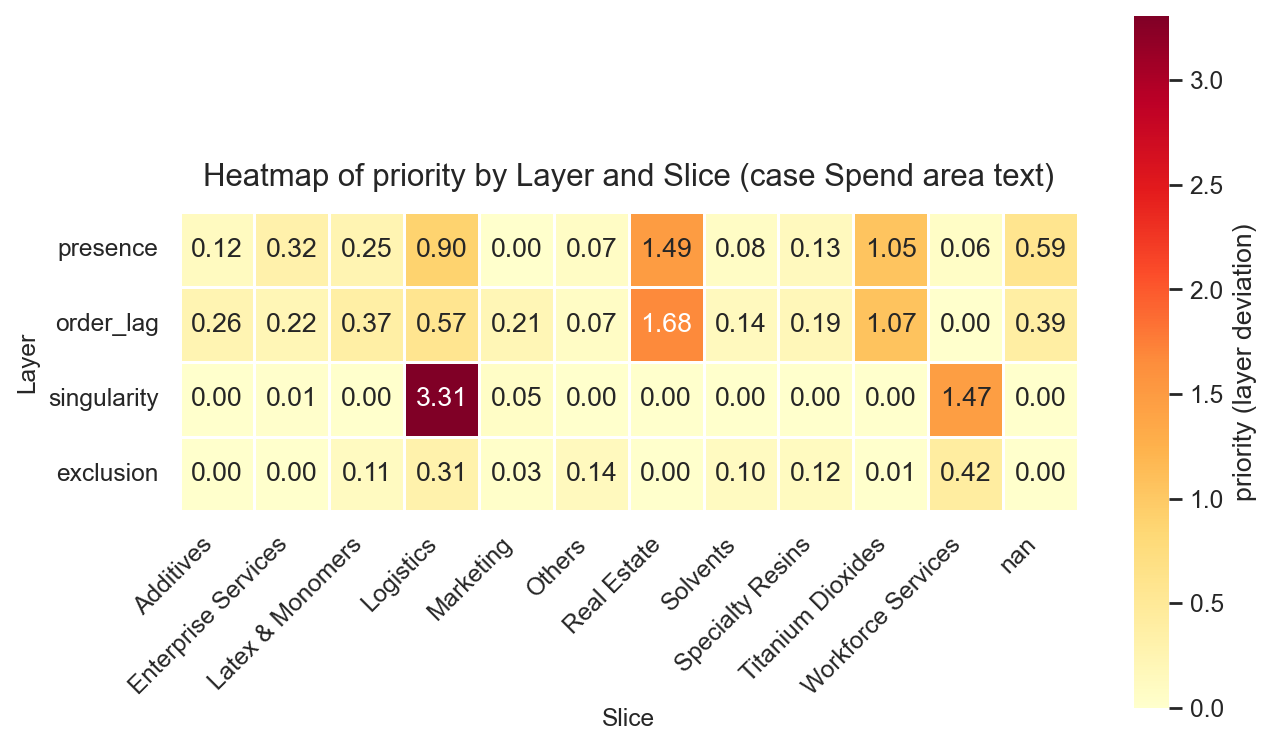

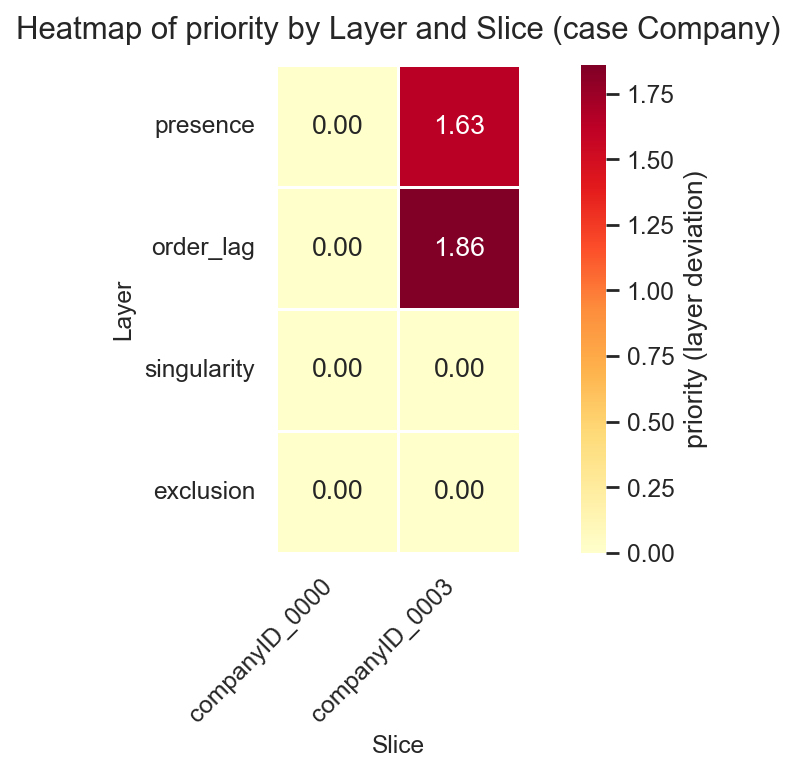

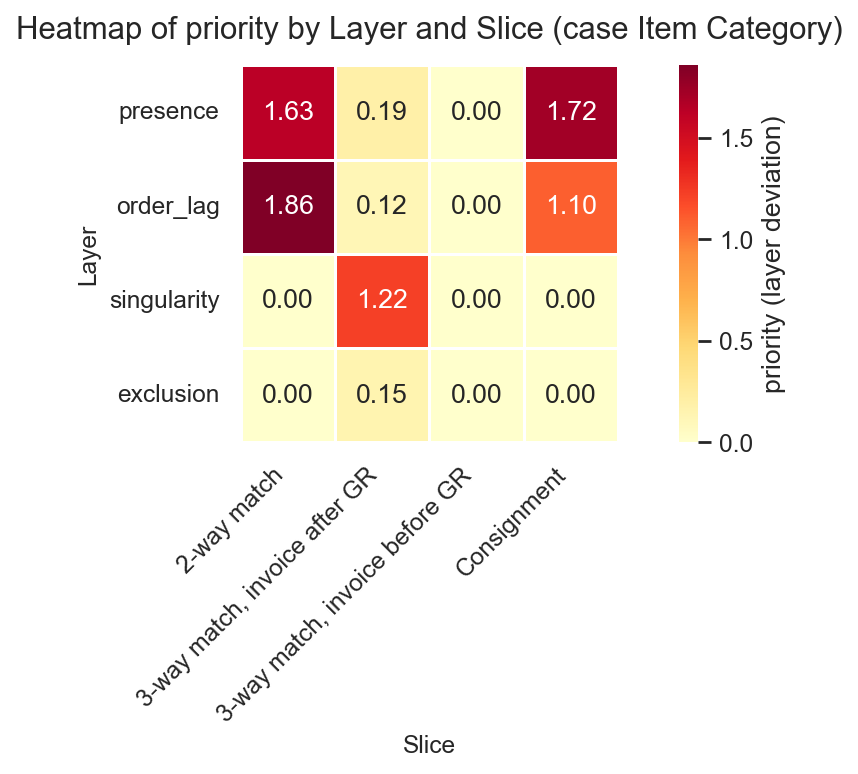

In [14]:
for dim in ["case Spend area text", "case Company", "case Item Category"]:
    if dim not in available_slice_cols:
        continue

    subset = layer_slice_table[layer_slice_table["dim"] == dim].copy()
    # Keep top 12 categories by total priority
    top_cats = (
        subset.groupby("category")["priority"]
        .sum()
        .sort_values(ascending=False)
        .head(12)
        .index
    )
    subset = subset[subset["category"].isin(top_cats)]
    subset["slice_label"] = subset["category"]

    plot_layer_slice_heatmap(
        subset,
        value_col="priority",
        title=f"Heatmap of priority by Layer and Slice ({dim})",
        vcenter=None,
        fmt=".2f",
        cmap="YlOrRd",
        figsize_scale=0.7,
    )


**Interpretation.**

- Rows = WISE layers (presence, order/lag, balance, singularity, exclusion).  
- Columns = slice categories (e.g. Spend areas, Companies, Item categories).  
- Colour and numbers = `priority` (volume‑weighted deviation, higher = worse).  
- Concentrated red cells highlight **where a specific type of problem
  concentrates** (e.g., singularity issues in Logistics consignment items).

---

## 7. Global “where to start” hotspot ranking

We now aggregate layer priorities into a flat ranking of slices.

In [15]:
@dataclass
class Hotspot:
    dim: str
    category: str
    n_cases: int
    total_priority: float
    top_layer: str
    top_layer_priority: float
    mean_score: float
    global_mean_score: float

def build_hotspot_ranking(
    case_scores: pd.DataFrame,
    df_log: pd.DataFrame,
    case_id_col: str,
    slice_cols: list[str],
    shrink_k: float = 50.0,
    min_cases: int = 30,
) -> pd.DataFrame:
    slice_df = df_log[[case_id_col] + slice_cols].drop_duplicates()
    joined = case_scores.merge(slice_df, on=case_id_col, how="left")

    global_mean_score = joined["score"].mean()

    hotspots: list[Hotspot] = []

    for dim in slice_cols:
        for cat, sub in joined.groupby(dim, dropna=False):
            cat_label = str(cat)
            n_s = sub[case_id_col].nunique()
            if n_s < min_cases:
                continue

            mean_score = sub["score"].mean()
            gap = global_mean_score - mean_score  # >0 => worse than global
            vol_weight = n_s / (n_s + shrink_k)

            # layer priorities from previously computed table
            sub_lp = layer_slice_table[
                (layer_slice_table["dim"] == dim)
                & (layer_slice_table["category"] == cat_label)
            ]
            if sub_lp.empty:
                continue

            layer_priorities = (
                sub_lp.set_index("layer_id")["priority"].to_dict()
            )
            top_layer = max(layer_priorities, key=layer_priorities.get)
            top_layer_priority = layer_priorities[top_layer]

            total_priority = sum(layer_priorities.values()) * gap

            hotspots.append(
                Hotspot(
                    dim=dim,
                    category=cat_label,
                    n_cases=n_s,
                    total_priority=total_priority,
                    top_layer=top_layer,
                    top_layer_priority=top_layer_priority,
                    mean_score=mean_score,
                    global_mean_score=global_mean_score,
                )
            )

    hot_df = pd.DataFrame([h.__dict__ for h in hotspots])
    return hot_df.sort_values("total_priority", ascending=False).reset_index(drop=True)

hotspots = build_hotspot_ranking(
    case_scores=case_scores,
    df_log=df_sub,
    case_id_col=CASE_ID_COL,
    slice_cols=available_slice_cols,
    shrink_k=50.0,
    min_cases=30,
)

hotspots.head(20)

dim                       category  n_cases  \
0             case Spend area text                      Logistics     5242   
1               case Item Category                    Consignment    14498   
2                   case Item Type                    Consignment    14498   
3               case Item Category                    2-way match     1044   
4                   case Item Type                          Limit     1044   
5               case Goods Receipt                          False     1044   
6                     case Company                 companyID_0003     1044   
7                   case Item Type                        Service     5838   
8               case Document Type                Framework order     1539   
9             case Spend area text                    Real Estate      584   
10            case Spend area text              Titanium Dioxides     1863   
11                  case Item Type                 Subcontracting     4678   
12              case Item Category  3-way match, invoice after GR    15182   
13       case GR-Based Inv. Verif.                           True    15182   
14  case Spend classification text                            nan     3289   
15            case Spend area text                            nan     3289   
16            case Spend area text               Latex & Monomers     5007   
17            case Spend area text             Workforce Services      128   
18            case Spend area text               Specialty Resins     2406   
19            case Spend area text                      Additives    18318   

    total_priority    top_layer  top_layer_priority  mean_score  \
0         0.745760  singularity            3.307844    0.700378   
1         0.572340     presence            1.722836    0.644008   
2         0.572340     presence            1.722836    0.644008   
3         0.518893    order_lag            1.857939    0.698189   
4         0.518893    order_lag            1.857939    0.698189   
5         0.518893    order_lag            1.857939    0.698189   
6         0.518893    order_lag            1.857939    0.698189   
7         0.510420  singularity            3.158718    0.733934   
8         0.479706    order_lag            1.262144    0.720618   
9         0.417284    order_lag            1.677067    0.715335   
10        0.286933    order_lag            1.069292    0.712234   
11        0.192097    order_lag            0.865267    0.737713   
12        0.060886  singularity            1.224541    0.810655   
13        0.060886  singularity            1.224541    0.810655   
14        0.056425     presence            0.587294    0.789518   
15        0.056425     presence            0.587294    0.789518   
16        0.036771    order_lag            0.370115    0.796267   
17        0.027006  singularity            1.467840    0.833110   
18        0.013047    order_lag            0.185245    0.817283   
19        0.009959    order_lag            0.255807    0.820353   

    global_mean_score  
0            0.846985  
1            0.846985  
2            0.846985  
3            0.846985  
4            0.846985  
5            0.846985  
6            0.846985  
7            0.846985  
8            0.846985  
9            0.846985  
10           0.846985  
11           0.846985  
12           0.846985  
13           0.846985  
14           0.846985  
15           0.846985  
16           0.846985  
17           0.846985  
18           0.846985  
19           0.846985

In [16]:
%%markdown
### How to use the hotspot ranking

Each row is a **“where to start” suggestion**:

- `dim` / `category` → which slice (e.g. `case Spend area text = Logistics`).  
- `n_cases`          → how many cases are affected.  
- `mean_score`       → average WISE score in that slice (1 = perfect).  
- `total_priority`   → combined layer deviation × volume (higher = more urgent).  
- `top_layer`        → which WISE layer contributes most to the problem.

A practical workflow:

1. Sort by `total_priority` and focus on the top 10–20 rows.  
2. For each, note the `dim`, `category`, and `top_layer`.  
3. Use the interactive drill‑down below to inspect **which constraints inside
   that layer** are most problematic for that slice.

### How to use the hotspot ranking

Each row is a **“where to start” suggestion**:

- `dim` / `category` → which slice (e.g. `case Spend area text = Logistics`).  
- `n_cases`          → how many cases are affected.  
- `mean_score`       → average WISE score in that slice (1 = perfect).  
- `total_priority`   → combined layer deviation × volume (higher = more urgent).  
- `top_layer`        → which WISE layer contributes most to the problem.

A practical workflow:

1. Sort by `total_priority` and focus on the top 10–20 rows.  
2. For each, note the `dim`, `category`, and `top_layer`.  
3. Use the interactive drill‑down below to inspect **which constraints inside
   that layer** are most problematic for that slice.


---

## 8. Interactive drill‑down: slice × layer → constraints

We build a small UI where you can select a slice dimension, a slice value and
a layer, and see which constraints inside that layer are driving the
problems.

In [17]:
# ===============================
# Interactive drilldown: slice × layer
# ===============================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, Button, VBox, HBox, Output
from IPython.display import display, clear_output

# --- Build constraint metadata from the norm ---

def describe_constraint(c) -> str:
    p = getattr(c, "params", {})
    lid = getattr(c, "layer_id", "unknown")
    if lid == "presence":
        return f"Presence of '{p.get('activity')}'"
    elif lid == "order_lag":
        return (
            f"Order/lag: '{p.get('activity_from')}' → '{p.get('activity_to')}' "
            f"≤ {p.get('max_days')} days"
        )
    elif lid == "balance":
        return (
            f"Balance: {p.get('qty_col_from')} vs {p.get('qty_col_to')} "
            f"(tol={p.get('tolerance')})"
        )
    elif lid == "singularity":
        return f"Singularity: at most once '{p.get('activity')}'"
    elif lid == "exclusion":
        return f"Exclusion: forbid '{p.get('activity')}'"
    else:
        return f"{lid}: {p}"

constraint_meta = pd.DataFrame(
    [
        {
            "constraint_id": c.id,
            "layer_id": c.layer_id,
            "description": describe_constraint(c),
        }
        for c in norm.constraints
    ]
)

# Map from constraint id to violation column in case_scores
viol_cols = [c for c in case_scores.columns if c.startswith("viol_")]
viol_col_map = {c[5:]: c for c in viol_cols}  # id -> column name


def drilldown_layer_slice(slice_dim: str, slice_value: str, layer_id: str, top_n: int = 10):
    """
    Show which constraints in a given layer are worst for the selected slice.
    """
    mask = df_sub[slice_dim] == slice_value
    case_ids = df_sub.loc[mask, CASE_ID_COL].unique()
    if len(case_ids) == 0:
        print("No cases in this slice.")
        return

    sub_scores = case_scores[case_scores[CASE_ID_COL].isin(case_ids)]
    print(f"{len(case_ids)} cases in slice '{slice_dim} = {slice_value}'.")

    rows = []
    for _, row in constraint_meta[constraint_meta["layer_id"] == layer_id].iterrows():
        cid = row["constraint_id"]
        col = viol_col_map.get(cid)
        if col is None or col not in case_scores.columns:
            continue

        global_mean = case_scores[col].mean()
        slice_mean = sub_scores[col].mean()
        gap = slice_mean - global_mean

        rows.append(
            {
                "constraint_id": cid,
                "description": row["description"],
                "global_mean_violation": global_mean,
                "slice_mean_violation": slice_mean,
                "gap": gap,
            }
        )

    if not rows:
        print("No violation columns found for this layer.")
        return

    df_c = pd.DataFrame(rows).sort_values("gap", ascending=False).head(top_n)

    display(
        df_c.style.format(
            {
                "global_mean_violation": "{:.3f}",
                "slice_mean_violation": "{:.3f}",
                "gap": "{:.3f}",
            }
        )
    )

    plt.figure(figsize=(8, max(4, 0.5 * len(df_c))), dpi=150)
    sns.barplot(data=df_c, x="gap", y="description", color="tab:red")
    plt.xlabel("Extra violation vs global (gap)")
    plt.ylabel("Constraint")
    plt.title(f"Worst '{layer_id}' constraints in slice '{slice_dim} = {slice_value}'")
    plt.tight_layout()
    plt.show()


# --- ipywidgets UI ---

# `available_slice_cols` must be defined earlier in your notebook (list of columns you use as slices)
dim_dropdown = Dropdown(
    options=available_slice_cols,
    description="Slice dim:",
    layout={"width": "260px"},
)

layer_dropdown = Dropdown(
    options=sorted(constraint_meta["layer_id"].unique()),
    description="Layer:",
    layout={"width": "200px"},
)

value_dropdown = Dropdown(
    description="Slice value:",
    layout={"width": "320px"},
)

run_button = Button(
    description="Show drilldown",
    button_style="primary",   # blue button
    layout={"width": "160px"},
)

out = Output()


def update_values(*args):
    """Update the slice value dropdown when the dimension changes."""
    dim = dim_dropdown.value
    vals = df_sub[dim].dropna().astype(str).unique()
    value_dropdown.options = sorted(vals)


def on_run_click(b):
    """Run the drilldown and display the output."""
    with out:
        clear_output(wait=True)
        drilldown_layer_slice(
            slice_dim=dim_dropdown.value,
            slice_value=value_dropdown.value,
            layer_id=layer_dropdown.value,
            top_n=10,
        )


# Wire up callbacks
dim_dropdown.observe(update_values, names="value")
run_button.on_click(on_run_click)

# Initialise the value dropdown once
update_values()

# Layout and display
controls = HBox([dim_dropdown, value_dropdown, layer_dropdown, run_button])
ui = VBox([controls, out])
display(ui)


In [18]:
import ipywidgets as widgets
from IPython.display import display

print("ipywidgets version:", widgets.__version__)

slider = widgets.IntSlider(description="Test")
display(slider)


ipywidgets version: 8.1.2


IntSlider(value=0, description='Test')

In [19]:
# --- ipywidgets UI ---

dim_dropdown = Dropdown(options=available_slice_cols, description="Slice dim:")
layer_dropdown = Dropdown(
    options=sorted(constraint_meta["layer_id"].unique()),
    description="Layer:",
)
value_dropdown = Dropdown(description="Slice value:")
out = Output()

def update_values(*args):
    dim = dim_dropdown.value
    vals = df_sub[dim].dropna().astype(str).unique()
    value_dropdown.options = sorted(vals)

def refresh_output(*args):
    with out:
        out.clear_output()
        if value_dropdown.value is None:
            return
        drilldown_layer_slice(
            slice_dim=dim_dropdown.value,
            slice_value=value_dropdown.value,
            layer_id=layer_dropdown.value,
            top_n=10,
        )

dim_dropdown.observe(update_values, names="value")
for w in (dim_dropdown, value_dropdown, layer_dropdown):
    w.observe(refresh_output, names="value")

update_values()
refresh_output()

VBox([HBox([dim_dropdown, value_dropdown, layer_dropdown]), out])

In [20]:
import ipywidgets as widgets
from IPython.display import display

# --- Build constraint metadata from the norm ---

def describe_constraint(c) -> str:
    p = getattr(c, "params", {})
    lid = getattr(c, "layer_id", "unknown")
    if lid == "presence":
        return f"Presence of '{p.get('activity')}'"
    elif lid == "order_lag":
        return (
            f"Order/lag: '{p.get('activity_from')}' → '{p.get('activity_to')}' "
            f"≤ {p.get('max_days')} days"
        )
    elif lid == "balance":
        return (
            f"Balance: {p.get('qty_col_from')} vs {p.get('qty_col_to')} "
            f"(tol={p.get('tolerance')})"
        )
    elif lid == "singularity":
        return f"Singularity: at most once '{p.get('activity')}'"
    elif lid == "exclusion":
        return f"Exclusion: forbid '{p.get('activity')}'"
    else:
        return f"{lid}: {p}"

constraint_meta = pd.DataFrame(
    [
        {
            "constraint_id": c.id,
            "layer_id": c.layer_id,
            "description": describe_constraint(c),
        }
        for c in norm.constraints
    ]
)

# Map from constraint id to violation column
viol_cols = [c for c in case_scores.columns if c.startswith("viol_")]
viol_col_map = {c[5:]: c for c in viol_cols}

def drilldown_layer_slice(slice_dim: str, slice_value: str, layer_id: str, top_n: int = 10):
    """
    Show which constraints in a given layer are worst for the selected slice.
    """
    if slice_dim not in df_sub.columns:
        print(f"Slice dimension '{slice_dim}' not in df_sub.")
        return

    mask = df_sub[slice_dim].astype(str) == str(slice_value)
    case_ids = df_sub.loc[mask, CASE_ID_COL].unique()
    if len(case_ids) == 0:
        print("No cases in this slice.")
        return

    sub_scores = case_scores[case_scores[CASE_ID_COL].isin(case_ids)]
    print(f"{len(case_ids)} cases in slice '{slice_dim} = {slice_value}'.")

    rows = []
    for _, row in constraint_meta[constraint_meta["layer_id"] == layer_id].iterrows():
        cid = row["constraint_id"]
        col = viol_col_map.get(cid)
        if col is None or col not in case_scores.columns:
            continue

        global_mean = case_scores[col].mean()
        slice_mean = sub_scores[col].mean()
        gap = slice_mean - global_mean

        rows.append(
            {
                "constraint_id": cid,
                "description": row["description"],
                "global_mean_violation": global_mean,
                "slice_mean_violation": slice_mean,
                "gap": gap,
            }
        )

    if not rows:
        print("No violation columns found for this layer.")
        return

    df_c = pd.DataFrame(rows).sort_values("gap", ascending=False).head(top_n)

    display(
        df_c.style.format(
            {
                "global_mean_violation": "{:.3f}",
                "slice_mean_violation": "{:.3f}",
                "gap": "{:.3f}",
            }
        )
    )

    plt.figure(figsize=(8, max(4, 0.5 * len(df_c))), dpi=150)
    sns.barplot(data=df_c, x="gap", y="description", color="tab:red")
    plt.xlabel("Extra violation vs global (gap)")
    plt.ylabel("Constraint")
    plt.title(f"Worst {layer_id} constraints in slice '{slice_dim} = {slice_value}'")
    plt.tight_layout()
    plt.show()


# --- ipywidgets UI with interact ---

# Create widgets
slice_dim_dropdown = widgets.Dropdown(
    options=available_slice_cols,
    description="Slice dim:",
    value=available_slice_cols[0] if available_slice_cols else None
)

slice_value_dropdown = widgets.Dropdown(
    options=[],
    description="Slice value:",
)

layer_dropdown = widgets.Dropdown(
    options=sorted(constraint_meta["layer_id"].unique()),
    description="Layer:",
)

run_button = widgets.Button(description="Analyze")
output_widget = widgets.Output()

# Update slice values when slice dimension changes
def update_slice_values(change):
    slice_dim = change['new']
    if slice_dim and slice_dim in df_sub.columns:
        vals = sorted(df_sub[slice_dim].dropna().astype(str).unique())
        slice_value_dropdown.options = vals
        if vals:
            slice_value_dropdown.value = vals[0]

slice_dim_dropdown.observe(update_slice_values, names='value')

# Initialize slice values for the first time
if slice_dim_dropdown.value:
    vals = sorted(df_sub[slice_dim_dropdown.value].dropna().astype(str).unique())
    slice_value_dropdown.options = vals
    if vals:
        slice_value_dropdown.value = vals[0]

# Button click handler
def on_run_button_clicked(b):
    with output_widget:
        output_widget.clear_output()
        drilldown_layer_slice(
            slice_dim=slice_dim_dropdown.value,
            slice_value=slice_value_dropdown.value,
            layer_id=layer_dropdown.value,
            top_n=10
        )

run_button.on_click(on_run_button_clicked)

# Display UI
display(
    widgets.VBox([
        slice_dim_dropdown,
        slice_value_dropdown,
        layer_dropdown,
        run_button,
        output_widget
    ])
)


**How to use the drill‑down**

1. Pick a slice dimension (e.g. `case Spend area text`).  
2. Pick a value (e.g. `Logistics`).  
3. Pick a layer (e.g. `singularity`).  

The table shows constraint‑level violations in that layer for the chosen slice,
compared to global behaviour. Large positive `gap` means “much more violation
here than globally” and should be treated as a specific root‑cause
hypothesis.

---

## 9. SHAP / LIME and clustering (optional XAI layer)

If `HAS_XAI` is `False`, install requirements first:

In [21]:
%%bash
pip install shap lime scikit-learn

=0.12 in /opt/miniconda3/envs/wise-env/lib/python3.10/site-packages (from lime) (0.25.2)


### 9.1 Prepare features & model

In [22]:
HAS_XAI

True

In [23]:
if HAS_XAI:
    feature_cols = available_slice_cols

    slice_df = df_sub[[CASE_ID_COL] + feature_cols].drop_duplicates()
    data_xai = case_scores[[CASE_ID_COL, "score"]].merge(
        slice_df, on=CASE_ID_COL, how="left"
    )

    y = 1.0 - data_xai["score"].values  # badness in [0,1]
    X = data_xai[feature_cols]

    categorical_features = feature_cols
    preprocess = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
        ]
    )

    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=8,
        random_state=42,
        n_jobs=-1,
    )

    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    pipe.fit(X_train, y_train)

    print("R² on hold-out:", pipe.score(X_test, y_test))

R² on hold-out: 0.25936802668073056


### 9.2 Global SHAP summary

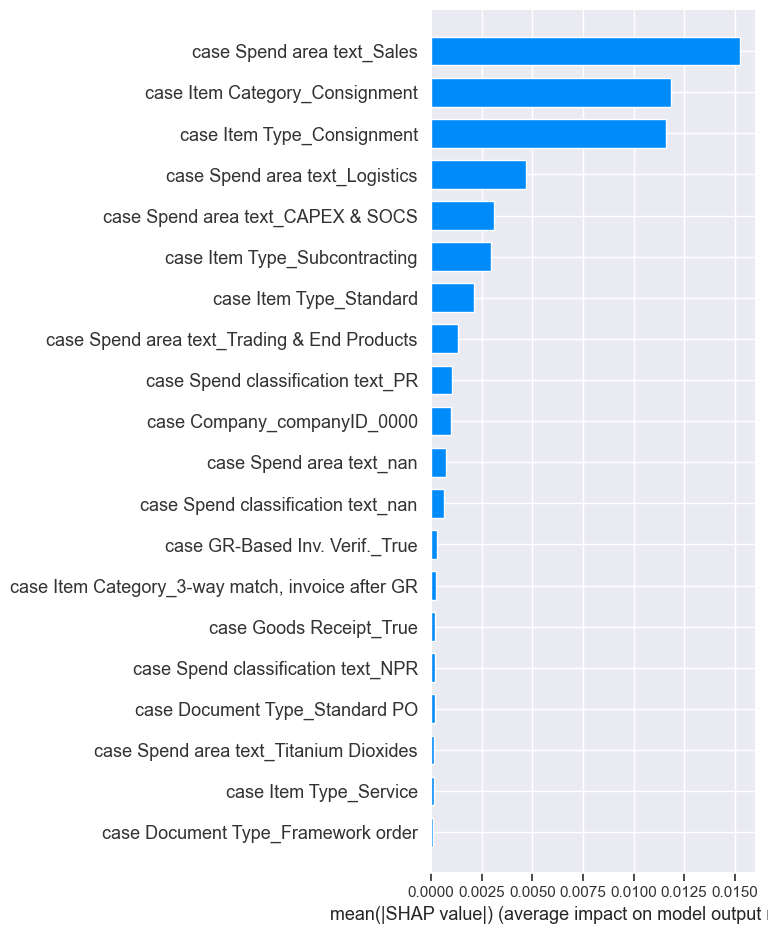

In [24]:
import numpy as np
import shap

# 1. Get the trained model and transformed features
model = pipe.named_steps["model"]
X_test_enc = pipe.named_steps["preprocess"].transform(X_test)

# 2. If it's sparse, densify
if hasattr(X_test_enc, "toarray"):
    X_test_enc = X_test_enc.toarray()

# 3. Force to a numeric float dtype
X_test_enc = np.asarray(X_test_enc, dtype=np.float64)

# (Optional but sometimes helpful) Drop rows that are all-NaN after encoding
# mask = ~np.isnan(X_test_enc).all(axis=1)
# X_test_enc = X_test_enc[mask]

# 4. Build SHAP explainer on the tree model
explainer = shap.TreeExplainer(model)

# 5. Compute SHAP values
shap_values = explainer.shap_values(X_test_enc)

# 6. Get feature names from the encoder if you want a nice summary plot
oh_cols = (
    pipe.named_steps["preprocess"]
    .named_transformers_["cat"]
    .get_feature_names_out(categorical_features)
)
# If you also passed numeric features through, you may want to concatenate a list of those names.

# 7. Summary plot
shap.summary_plot(
    shap_values,
    X_test_enc,
    feature_names=oh_cols,
    plot_type="bar",
    max_display=20,
)


5242 cases in slice 'case Spend area text = Logistics'.


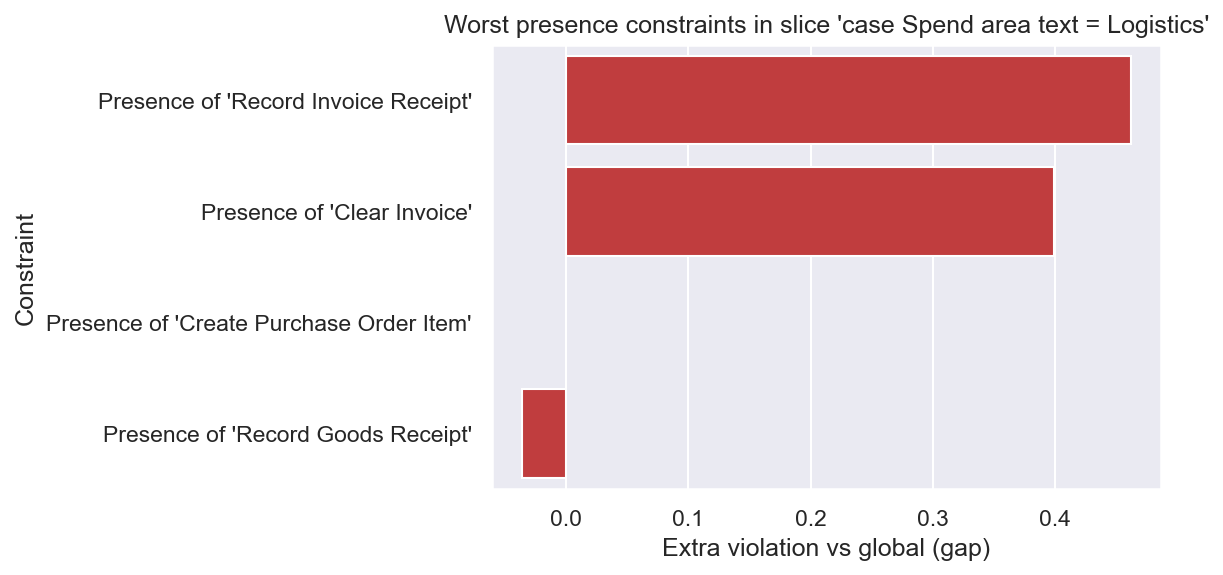

In [25]:
drilldown_layer_slice(
    slice_dim="case Spend area text",
    slice_value="Logistics",
    layer_id="presence",
    top_n=10,
)



**Reading the SHAP summary.**

- Each bar is an encoded feature level, e.g. `case Spend area text = Logistics`.  
- Bar length ~= average absolute impact on **badness**.  
- Large positive mean SHAP → increases badness (worse behaviour).  
- Large negative mean SHAP → decreases badness (healthier behaviour).

### 9.3 Local SHAP for a single bad case

X_test_enc type: <class 'numpy.ndarray'> dtype: float64


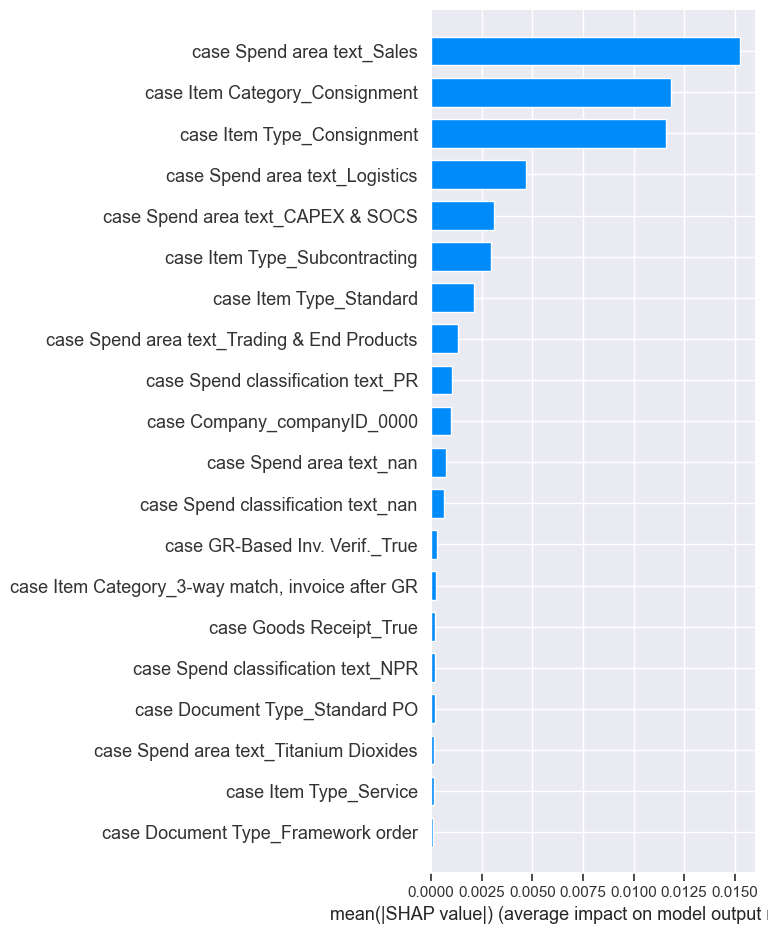

In [28]:
import numpy as np
import shap

# 1. Get trained model and transformed features
model = pipe.named_steps["model"]
X_test_enc = pipe.named_steps["preprocess"].transform(X_test)

# 2. If the encoded matrix is sparse, densify it
if hasattr(X_test_enc, "toarray"):
    X_test_enc = X_test_enc.toarray()

# 3. Force to dense numeric float dtype (this fixes the UFuncTypeError)
X_test_enc = np.asarray(X_test_enc, dtype=np.float64)

print("X_test_enc type:", type(X_test_enc), "dtype:", X_test_enc.dtype)

# 4. Build SHAP explainer on the tree model
explainer = shap.TreeExplainer(model)

# 5. Compute SHAP values (now works because input is numeric float)
shap_values = explainer.shap_values(X_test_enc)

# 6. Get feature names from the encoder (for nicer plots)
oh_cols = (
    pipe.named_steps["preprocess"]
    .named_transformers_["cat"]
    .get_feature_names_out(categorical_features)
)

# If you also have numeric passthrough features, you can extend this list, e.g.:
# feature_names = list(oh_cols) + numeric_features
feature_names = list(oh_cols)

# 7. Global summary plot
shap.summary_plot(
    shap_values,
    X_test_enc,
    feature_names=feature_names,
    plot_type="bar",
    max_display=20,
)


### 9.4 Cluster slices by layer violation pattern

slice_value  violation_exclusion  violation_order_lag  \
0                   Additives             0.009089             0.480700   
1                CAPEX & SOCS             0.014108             0.281199   
2   Chemicals & Intermediates             0.000000             0.377778   
3            Commodity Resins             0.007946             0.392679   
4                      Energy             0.016667             0.866667   
5         Enterprise Services             0.004142             0.475485   
6            Latex & Monomers             0.014729             0.510268   
7                   Logistics             0.025229             0.561569   
8                   Marketing             0.010748             0.471316   
9                      Others             0.016414             0.433957   
10                  Packaging             0.005192             0.434876   
11       Pigments & Colorants             0.011473             0.434184   
12                Real Estate             0.001712             0.874952   
13                      Sales             0.009706             0.335462   
14                   Solvents             0.014549             0.451469   
15           Specialty Resins             0.015378             0.463709   
16    Spend Area Unidentified             0.013889             0.500463   
17          Titanium Dioxides             0.009528             0.692801   
18     Trading & End Products             0.016721             0.425068   
19         Workforce Services             0.039062             0.332075   
20                        NaN             0.009121             0.516602   

    violation_presence  violation_singularity  cluster  
0             0.151504               0.016312        1  
1             0.101492               0.016546        1  
2             0.000000               0.000000        1  
3             0.085575               0.009780        1  
4             0.400000               0.013333        2  
5             0.203313               0.025000        1  
6             0.181346               0.018414        1  
7             0.330885               0.314689        0  
8             0.115857               0.028476        1  
9             0.141461               0.017685        1  
10            0.127854               0.016420        1  
11            0.138160               0.019051        1  
12            0.493151               0.002740        2  
13            0.073037               0.015902        1  
14            0.142545               0.010803        1  
15            0.155964               0.012968        1  
16            0.166667               0.022222        1  
17            0.370102               0.010843        2  
18            0.126379               0.028486        1  
19            0.144531               0.201563        3  
20            0.260337               0.017878        1

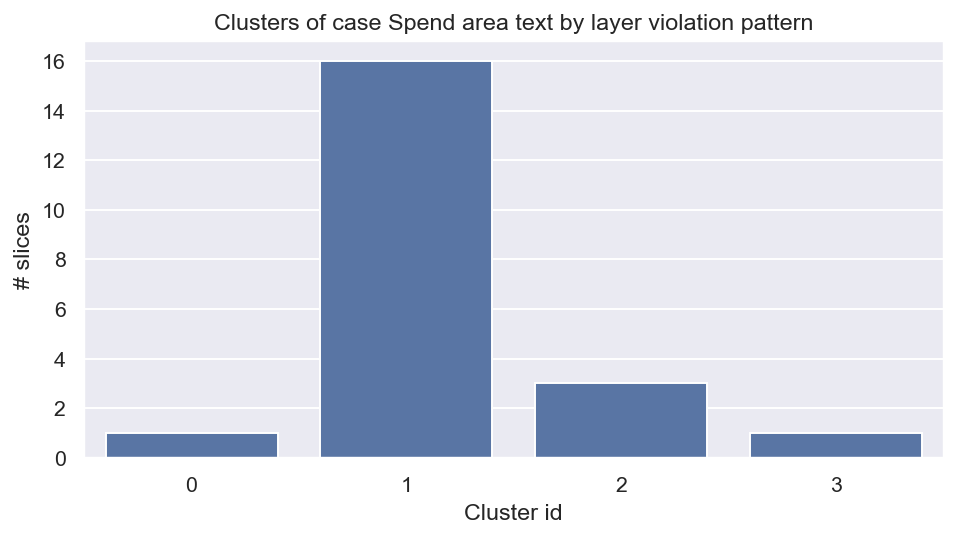

In [29]:
if HAS_XAI:
    layer_cols = [c for c in case_scores.columns if c.startswith("violation_")]
    slice_dim = "case Spend area text"  # choose dimension to cluster

    if slice_dim in available_slice_cols:
        slice_df2 = df_sub[[CASE_ID_COL, slice_dim]].drop_duplicates()
        joined2 = case_scores.merge(slice_df2, on=CASE_ID_COL, how="left")

        agg = (
            joined2.groupby(slice_dim, dropna=False)[layer_cols]
            .mean()
            .reset_index()
            .rename(columns={slice_dim: "slice_value"})
        )

        X_layer = agg[layer_cols].fillna(0.0)
        scaler = StandardScaler()
        X_norm = scaler.fit_transform(X_layer)

        kmeans = KMeans(n_clusters=4, random_state=42)
        agg["cluster"] = kmeans.fit_predict(X_norm)

        display(agg)

        plt.figure(figsize=(7, 4), dpi=140)
        sns.countplot(data=agg, x="cluster")
        plt.title(f"Clusters of {slice_dim} by layer violation pattern")
        plt.xlabel("Cluster id")
        plt.ylabel("# slices")
        plt.tight_layout()
        plt.show()


Clusters group slices that misbehave in **similar ways**. For example:

- Cluster 0: strong presence/order problems → fix basic process hygiene.  
- Cluster 1: strong singularity/exclusion → focus on rework, late changes.  

This helps design targeted improvement programmes.

### 9.5 Optional LIME example

In [30]:
if HAS_XAI:
    X_enc_full = pipe.named_steps["preprocess"].transform(X)
    feature_names = oh_cols

    explainer_lime = LimeTabularExplainer(
        training_data=X_enc_full.toarray()
        if hasattr(X_enc_full, "toarray")
        else X_enc_full,
        feature_names=feature_names,
        mode="regression",
    )

    i = np.random.randint(0, X_test.shape[0])
    x_instance = X_test.iloc[i]
    x_enc = pipe.named_steps["preprocess"].transform(x_instance.to_frame().T)

    exp = explainer_lime.explain_instance(
        x_enc.toarray()[0] if hasattr(x_enc, "toarray") else x_enc[0],
        lambda z: pipe.named_steps["model"].predict(z),
        num_features=10,
    )

    exp.show_in_notebook(show_table=True)

---

## 10. From analytics to actions (for stakeholders)

### How to turn this into an improvement backlog

1. **Choose a view and process type**, then run the notebook.  
2. **Inspect the hotspot ranking** and take the top 10–20 rows: these are
   slice candidates where deviations from the norm are both large and frequent.  
3. **Use heatmaps** per dimension to confirm which slices and layers
   stand out (red cells).  
4. **Drill down interactively**: for each high‑priority slice, inspect the
   constraints inside the problematic layer(s) and phrase them in business
   language (e.g. “logistics POs often change price after GR”).  
5. **Use SHAP / LIME** to explain individual bad cases when you need concrete,
   example‑level narratives for stakeholders.  
6. **Cluster slices** to group segments that require similar fixes, which helps
   when designing playbooks or global standards.  

All metrics are on a consistent scale:

- Case `score` in $[0,1]$: closer to 1 is better.  
- `badness = 1 - score` in $[0,1]$: closer to 1 is worse.  
- Layer violations in $[0,1]$: closer to 0 is better.  
- Gaps and priorities: larger positive values mean “worse than global” and
  should be treated as more urgent.

This brings together WISE’s norm‑based scoring, slice‑first analytics, and
XAI‑style explanations into one coherent story for P2P stakeholders.